In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mutual_info_score
from sklearn.pipeline import make_pipeline

!pip install tqdm
from tqdm.auto import tqdm

import pickle

In [2]:
# Read the data from the csv file into a dataframe
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
df.shape

(100000, 9)

In [4]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='str')

In [5]:
# Check for missing values

df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [6]:
# check the data types in the data frame
df.dtypes

gender                     str
age                    float64
hypertension             int64
heart_disease            int64
smoking_history            str
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

In [7]:
# loan_id is redundant and can be deleted
df.tail()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0
99999,Female,57.0,0,0,current,22.43,6.6,90,0


In [8]:
# Get the names of the numerical features and the categorical features

categorical = list(df.dtypes[df.dtypes=='str'].index)
categorical

['gender', 'smoking_history']

In [9]:
numerical = list(df.dtypes[df.dtypes!='str'].index)
numerical

['age',
 'hypertension',
 'heart_disease',
 'bmi',
 'HbA1c_level',
 'blood_glucose_level',
 'diabetes']

In [10]:
# Examine the values of the categorical

for value in categorical:
    print(df[value].value_counts().index)

Index(['Female', 'Male', 'Other'], dtype='str', name='gender')
Index(['No Info', 'never', 'former', 'current', 'not current', 'ever'], dtype='str', name='smoking_history')


In [11]:
# First remove the spaces in 'No Info' and 'not current'
df['smoking_history'] = df['smoking_history'].str.replace('No Info', 'No_Info')
df['smoking_history'] = df['smoking_history'].str.replace('not current', 'not_current')
df['smoking_history'].head()


0      never
1    No_Info
2      never
3    current
4    current
Name: smoking_history, dtype: str

In [12]:
# Continue editing the values of the categorical to remove the remaining extra spaces
for value in categorical:
    df[value] = df[value].str.lower().str.replace(' ','')

for value in categorical:
    print(df[value].value_counts().index)

Index(['female', 'male', 'other'], dtype='str', name='gender')
Index(['no_info', 'never', 'former', 'current', 'not_current', 'ever'], dtype='str', name='smoking_history')


In [13]:
# Examine the unique values of the categoricals

df[categorical].nunique()

gender             3
smoking_history    6
dtype: int64

In [14]:
# We can examine the numerical columns (i.e. features)

df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [15]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,female,80.0,0,1,never,25.19,6.6,140,0
1,female,54.0,0,0,no_info,27.32,6.6,80,0
2,male,28.0,0,0,never,27.32,5.7,158,0
3,female,36.0,0,0,current,23.45,5.0,155,0
4,male,76.0,1,1,current,20.14,4.8,155,0


In [16]:
# Update the new numerical variables to exclude the target variable, diabetes
numerical = numerical[:-1]
numerical

['age',
 'hypertension',
 'heart_disease',
 'bmi',
 'HbA1c_level',
 'blood_glucose_level']

<Axes: xlabel='diabetes', ylabel='Count'>

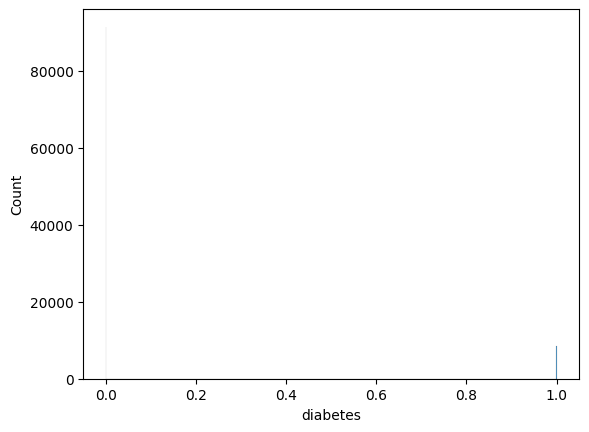

In [17]:
# Plot the histogram of the features to see their distribution
sns.histplot(df.diabetes)

In [18]:
# Try to normalize the distribution if not normalized
df.diabetes.value_counts(normalize=True)

diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64

In [19]:
# Proportion of positive diabetes values. The dataset is imbalanced with more non-diabetic cases
df.diabetes.mean()

np.float64(0.085)

In [20]:
# Split the data into train, validation and test sets (60%, 20%, 20%)

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [21]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, shuffle=False)

In [22]:
len(df_train) + len(df_val) + len(df_test) == len(df)

True

In [23]:
# Retreive the values of the target variable
y_full_train = df_full_train.diabetes.values
y_train = df_train.diabetes.values
y_val = df_val.diabetes.values
y_test = df_test.diabetes.values

In [24]:
len(y_train) + len(y_val) + len(y_test) == len(df)

True

In [25]:
# Compute feature importance (mutual information for categorical features)
def mutual_info_diabetes_score(series):
    return mutual_info_score(series, df_full_train.diabetes)

mi = df_full_train[categorical+numerical].apply(mutual_info_diabetes_score)

mi.sort_values(ascending=False)

mi

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:69: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:69: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:69: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


gender                 0.000569
smoking_history        0.009735
age                    0.040896
hypertension           0.013746
heart_disease          0.009694
bmi                    0.050419
HbA1c_level            0.130316
blood_glucose_level    0.111615
dtype: float64

In [26]:
# Compute feature importance (correlation information for numerical features)
# Correlation matrix for the numerial variables
full_numerical = list(df.dtypes[df.dtypes!='str'].index)
corr_matrix = np.zeros([len(full_numerical),len(full_numerical)])
i = 0
for col in full_numerical:
    corr_matrix[i,:] = df_full_train[full_numerical].corrwith(df_full_train[col]).abs()
    i = i+1
corr_matrix.round(3)

array([[1.   , 0.251, 0.234, 0.337, 0.101, 0.108, 0.257],
       [0.251, 1.   , 0.12 , 0.149, 0.081, 0.086, 0.2  ],
       [0.234, 0.12 , 1.   , 0.061, 0.07 , 0.072, 0.174],
       [0.337, 0.149, 0.061, 1.   , 0.085, 0.093, 0.216],
       [0.101, 0.081, 0.07 , 0.085, 1.   , 0.165, 0.401],
       [0.108, 0.086, 0.072, 0.093, 0.165, 1.   , 0.419],
       [0.257, 0.2  , 0.174, 0.216, 0.401, 0.419, 1.   ]])

In [27]:
full_numerical

['age',
 'hypertension',
 'heart_disease',
 'bmi',
 'HbA1c_level',
 'blood_glucose_level',
 'diabetes']

In [28]:
# Compute the correlation matrix to see the dependence of the numberical features on the target variable
df_full_train[numerical].corrwith(df_full_train['diabetes']).abs().sort_values(ascending=False)

blood_glucose_level    0.418641
HbA1c_level            0.401465
age                    0.256911
bmi                    0.216147
hypertension           0.199727
heart_disease          0.174035
dtype: float64

In [29]:
# Delete the target variable from the dataframes
#del df_full_train['loan_status']
del df_train['diabetes']
del df_val['diabetes']
del df_test['diabetes']

In [31]:
# Training the model
# One-hot encoding
dv = DictVectorizer(sparse=False)

In [32]:
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
X_train.shape

(60000, 15)

In [33]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)
X_val.shape

(20000, 15)

In [34]:
test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)
X_test.shape

(20000, 15)

In [66]:
# MODEL TRAINING
### Logistic Regression classifier

model = LogisticRegression(solver='lbfgs', C=1.0, max_iter=1000) # solver=’lbfgs’, solver='liblinear'
# solver='lbfgs' produces a better roc_auc_score and accuracy than solver='liblinear'
model.fit(X_train, y_train)

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [67]:
#model.intercept_, model.coef_

In [68]:
y_pred = model.predict_proba(X_val)[:,1]
#y_pred

In [69]:
round(roc_auc_score(y_val, y_pred),2)

0.96

In [70]:
# Computing the model accuracy for a given threshold value
diabetes_staus = y_pred>=0.5
(y_val == diabetes_staus).mean()  

np.float64(0.9602)

In [71]:
# RMSE
def rmse(y_val, y_pred):
    square_error = (y_val - y_pred)**2
    MSE = np.mean(square_error)
    return np.sqrt(MSE)

In [72]:
rmse_score = rmse(y_val, y_pred)
rmse_score

np.float64(0.17772061426162905)

In [73]:
# Calculating precision and recall for varying threshold values from 0 to 1 with incremental step of 0.01
scores = []
np.seterr(divide='ignore', invalid='ignore') # to allow division by zero
thresholds = np.linspace(0,1,101)
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    #print(tp, tn, fp, fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    fpr = fp / (fp + tn)
    f1 = (2 * precision * recall) / (precision + recall)

    scores.append((t, tp, tn, fp, fn, precision, recall, fpr, f1))

In [74]:
# Creating a dataframe to show metrics
columns = ['threshold', 'tp', 'tn','fp','fn','precision','recall','fpr', 'f1']
df_scores = pd.DataFrame(scores, columns=columns)
#df_scores

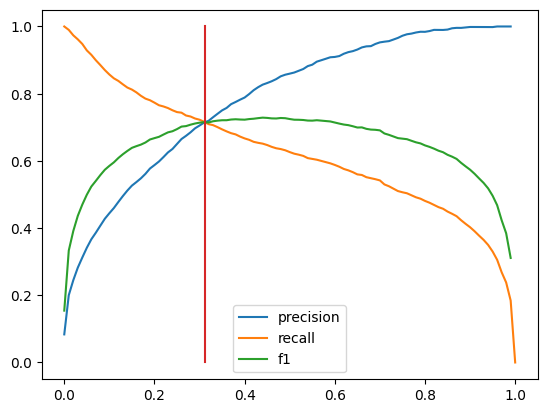

In [75]:
# Visualising the results
plt.plot(thresholds, df_scores.precision, label='precision')
plt.plot(thresholds, df_scores.recall, label='recall')
plt.plot(thresholds, df_scores.f1, label='f1')
plt.legend()
plt.plot([0.312,0.312], [0, 1])

In [76]:
# To look in the values of threshold where precision and recall are equal
#df_scores.loc[20:50]

In [81]:
# KFold cross-validation
# To obtain better model roc_auc_score

n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
scores = []
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.diabetes.values
    y_val = df_val.diabetes.values

    df_train = df_train[numerical + categorical]
    df_val = df_val[numerical + categorical]
    
    # Training the model
    # One-hot encoding
    dv = DictVectorizer(sparse=False)
    train_dict = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000) #lbfgs
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:,1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.4f, +- %.4f' % (np.mean(scores), np.std(scores)))

0it [00:00, ?it/s]

0.9617, +- 0.0017


In [82]:
# Hyperparameter tuning of Logistic Regression classifier with K-fold cross-validation

#C = [0.000001, 0.001, 1, 5, 10, 50, 100]

n_splits = 5

for C in tqdm([0.000001, 0.001, 1, 5, 10, 50, 100]):
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.diabetes.values
        y_val = df_val.diabetes.values

        del df_train['diabetes']
        del df_val['diabetes']
        
        # Training the model
        # One-hot encoding
        dv = DictVectorizer(sparse=False)
        train_dict = df_train.to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)
    
        val_dict = df_val.to_dict(orient='records')
        X_val = dv.transform(val_dict)
    
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
    
        y_pred = model.predict_proba(X_val)[:,1]
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print('C=%s %.3f, +- %.3f' % (C, round(np.mean(scores),3), round(np.std(scores),3)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=1e-06 0.158, +- 0.005
C=0.001 0.743, +- 0.006
C=1 0.962, +- 0.002
C=5 0.962, +- 0.002
C=10 0.962, +- 0.002
C=50 0.962, +- 0.002
C=100 0.962, +- 0.002


In [83]:
# C = 1, is the best parameter because it has the lowest value and 
# the best possible mean score for in the worst case of the standard deviation

In [84]:
### Decision Tree Classifier

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

dt = DecisionTreeClassifier(max_depth=1, random_state=1) # max_depth=1 to be tuned later
dt.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",1
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",1
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current nod

In [85]:
y_pred = dt.predict_proba(X_val)[:,1]
#y_pred
roc_auc_score(y_val, y_pred)

0.7296296296296296

In [86]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- HbA1c_level <= 6.70
|   |--- class: 0
|--- HbA1c_level >  6.70
|   |--- class: 1



In [87]:
scores = []
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth = d, random_state=1)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[ :, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%4s -> %.3f' % (d, auc))
    score = rmse(y_val, y_pred)
    scores.append((d, score))

   1 -> 0.730
   2 -> 0.835
   3 -> 0.898
   4 -> 0.931
   5 -> 0.953
   6 -> 0.966
  10 -> 0.974
  15 -> 0.944
  20 -> 0.882
None -> 0.858


In [88]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'rmse'])
df_scores.rmse = np.round(df_scores.rmse, 3)
df_scores

,max_depth,rmse
0,1.0,0.208
1,2.0,0.164
2,3.0,0.163
3,4.0,0.160
4,5.0,0.157
5,6.0,0.154
6,10.0,0.152
7,15.0,0.168
8,20.0,0.199
9,NaN,0.217


In [89]:
# Best depth=10
rf = RandomForestClassifier(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",10
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [90]:
y_pred = rf.predict_proba(X_val)[:,1]
#y_pred
roc_auc_score(y_val, y_pred)

0.925794387561623

In [91]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:,1]
    score = rmse(y_val, y_pred)
    scores.append((n, score))

In [92]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_scores.rmse = np.round(df_scores.rmse, 3)
df_scores

,n_estimators,rmse
0,10,0.165
1,20,0.162
2,30,0.161
3,40,0.160
4,50,0.159
5,60,0.159
6,70,0.159
7,80,0.159
8,90,0.159
9,100,0.159


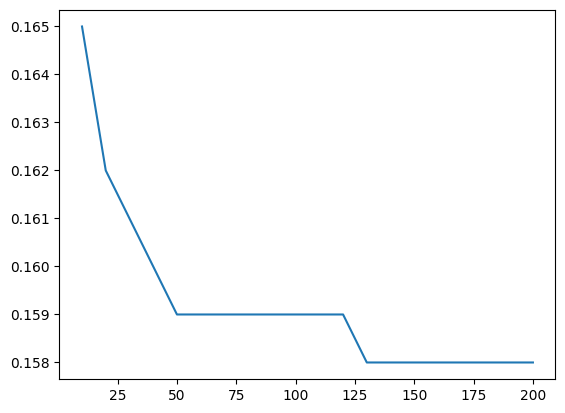

In [93]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [94]:
mean_scores = []
scores = []
for d in [6, 10, 20]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        score = rmse(y_val, y_pred)
        scores.append(score)
    mean_scores.append((d, np.mean(scores)))
    scores=[]

In [95]:
df_mean_scores = pd.DataFrame(mean_scores, columns=['max_depth','mean_rmse'])
df_mean_scores

,max_depth,mean_rmse
0,6,0.167030
1,10,0.166583
2,20,0.169492


In [96]:
# Computing feature_importance_

rf = RandomForestClassifier(n_estimators=60, max_depth=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feat_importances = pd.Series(importances, index=dv.get_feature_names_out())

print(feat_importances.sort_values(ascending=False))

HbA1c_level                    5.183128e-01
blood_glucose_level            3.489046e-01
age                            5.243586e-02
bmi                            3.957468e-02
hypertension                   1.600332e-02
heart_disease                  1.395166e-02
smoking_history=no_info        3.925051e-03
smoking_history=former         2.358720e-03
gender=male                    1.151040e-03
gender=female                  1.065262e-03
smoking_history=current        6.437637e-04
smoking_history=never          6.235713e-04
smoking_history=ever           6.140592e-04
smoking_history=not_current    4.354078e-04
gender=other                   2.338555e-07
dtype: float64


In [97]:
del df_full_train['diabetes']

In [98]:
# Final model
# Best model is the Decision Tree classifier with max_depth=10, resulting in roc_auc_score=0.974 and rmse=0.152

full_train_dict = df_full_train.to_dict(orient='records')
X_full_train = dv.fit_transform(full_train_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

dt = DecisionTreeClassifier(max_depth = 10, random_state=1)
dt.fit(X_full_train, y_full_train)
y_pred = dt.predict_proba(X_test)[ :, 1]
auc = roc_auc_score(y_test, y_pred)
auc

0.9736386554791931

In [99]:
rmse(y_test, y_pred)

np.float64(0.15339847450061433)

In [100]:
pipeline = make_pipeline(
    DictVectorizer(),
    DecisionTreeClassifier(max_depth = 10, random_state=1)
)

pipeline.fit(full_train_dict, y_full_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('dictvectorizer', ...), ('decisiontreeclassifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"dtype dtype: dtype, default=np.float64The type of feature values. Passed to Numpy array/scipy.sparse matrixconstructors as the dtype argument.",<class 'numpy.float64'>
,"separator separator: str, default=""=""Separator string used when constructing new features for one-hotcoding.",'='
,"sparse sparse: bool, default=TrueWhether transform should produce scipy.sparse matrices.",True
,"sort sort: bool, default=TrueWhether ``feature_names_`` and ``vocabulary_`` should besorted when fitting.",True
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10


In [101]:
y_pred = pipeline.predict_proba(test_dict)[:,1]

In [103]:
#y_pred

In [104]:
auc = roc_auc_score(y_test, y_pred)
auc

0.9736386554791931

In [105]:
rmse(y_test, y_pred)

np.float64(0.15339847450061433)

In [108]:
# Saving the model
#with open('model.bin', 'wb') as f_out:
#    pickle.dump(pipeline, f_out)


In [1]:
# Restart Kernel and run code from here to test that the model saved correctly and can do correct predictions
import pickle

In [2]:
with open('model.bin', 'rb') as f_in:
    pipeline = pickle.load(f_in)

In [3]:
pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('dictvectorizer', ...), ('decisiontreeclassifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"dtype dtype: dtype, default=np.float64The type of feature values. Passed to Numpy array/scipy.sparse matrixconstructors as the dtype argument.",<class 'numpy.float64'>
,"separator separator: str, default=""=""Separator string used when constructing new features for one-hotcoding.",'='
,"sparse sparse: bool, default=TrueWhether transform should produce scipy.sparse matrices.",True
,"sort sort: bool, default=TrueWhether ``feature_names_`` and ``vocabulary_`` should besorted when fitting.",True
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10


In [4]:
# 1:  6 female, 26 Male
# 0: 3 female, 4 Male

In [5]:
#client_f_db = df.loc[3].to_dict()
#client_f_db

In [6]:
client_male_diabetic = {
    'gender': 'Male',
     'age': 67.0,
     'hypertension': 0,
     'heart_disease': 1,
     'smoking_history': 'not current',
     'bmi': 27.32,
     'HbA1c_level': 6.5,
     'blood_glucose_level': 200
}

client_female_diabetic = {
    'gender': 'Female',
     'age': 44.0,
     'hypertension': 0,
     'heart_disease': 0,
     'smoking_history': 'never',
     'bmi': 19.31,
     'HbA1c_level': 6.5,
     'blood_glucose_level': 200
}

client_male_nondiabetic = {
    'gender': 'Male',
     'age': 76.0,
     'hypertension': 1,
     'heart_disease': 1,
     'smoking_history': 'current',
     'bmi': 20.14,
     'HbA1c_level': 4.8,
     'blood_glucose_level': 155
}

client_female_nondiabetic = {
    'gender': 'Female',
     'age': 36.0,
     'hypertension': 0,
     'heart_disease': 0,
     'smoking_history': 'current',
     'bmi': 23.45,
     'HbA1c_level': 5.0,
     'blood_glucose_level': 155
}

In [17]:
pipeline.predict_proba(client_female_diabetic)[:, 1]

array([0.03080041])